In [1]:
import pickle
import numpy as np
from tqdm import tqdm
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Input, Reshape, MaxPooling2D

Using TensorFlow backend.


In [2]:
data = pickle.load(open('../../../../../get_data/collman15_downsample.pkl', 'rb'))
print(data.keys())

dict_keys(['gephyrin594', 'MBP488', 'GABA488', 'GAD647', 'VGluT1_647', 'annotation', 'PSD95_488', 'NR1594', 'GS594', 'Synapsin647'])


In [3]:
class FeatureEncoder:
    
    def __init__(self,
                 input_shape,
                 hidden_size,
                 num_filters,
                 kernel_size):
        
        self._input_shape = input_shape
        self._hidden_size = hidden_size
        self._num_filters = num_filters
        self._kernel_size = kernel_size
        
        self._compressed_img_shape = None
        self._flattened_shape = None
        self._latent_shape = None
        self._thing = None
        
        
        self._encoder_fn = self.build_encoder_fn()
        self._decoder_fn = self.build_decoder_fn()
        
        x = Input(input_shape)
        latent_space = self._encoder_fn(x)
        x_hat = self._decoder_fn(latent_space)
        
        self._reconstruction_model = Model(inputs=[x],
                                           outputs=[x_hat])
        
        loss_fn = self.build_loss_fn()
        
        self._optimizer = Adam(lr=.001,
                               beta_1=.8,
                               beta_2=.999,
                               decay=.99)
        
        self._reconstruction_model.compile(loss=loss_fn,
                                           optimizer='adadelta')
        
        
    def build_encoder_fn(self):
        input_tensor = Input(self._input_shape)
       
        conv1 = Conv2D(self._num_filters,
                       self._kernel_size,
                       strides=(2, 2),
                       padding='same',
                       activation='relu')(input_tensor)
        
        #slice is done here to remove batch axis
        self._compressed_img_shape = list(K.int_shape(conv1))[1:]
        
        fc_in = Flatten()(conv1)
        
        #slice is done here to remove batch axis
        self._flattened_shape = list(K.int_shape(fc_in))[1:]
        
        fc1=Dense(self._hidden_size,
                  activation='relu')(fc_in)
        
        self._latent_shape = list(K.int_shape(fc1))[1:]
        
        return Model(input_tensor, fc1)
    
    
    def build_decoder_fn(self):
        input_tensor = Input(self._latent_shape)
        
        fc2 = Dense(self._flattened_shape[0],
                    activation='relu')(input_tensor)
       
        convt1_in = Reshape(self._compressed_img_shape)(fc2)
        
        convt1 = Conv2DTranspose(2,
                                 kernel_size=self._kernel_size,
                                 strides=(2, 2),
                                 padding='same',
                                 activation='relu')(convt1_in)
        
        return Model(input_tensor, convt1)
        
    
    def build_loss_fn(self):
        def loss_fn(y_true, y_pred):
            mse = K.mean(K.square(y_true - y_pred), axis=-1)
            return mse
        return loss_fn
    
    
    def train(self, batch):
        batch_loss = self._reconstruction_model.train_on_batch(batch, batch)
        return batch_loss
    
    
    def reconstruct(self, batch):
        return self._reconstruction_model.predict(batch)

In [10]:
def run_train_sim(n):
        
    def make_positive_example(input_shape, max_r, delta_r, size):
        
        example = np.stack([np.zeros(input_shape),
                            np.zeros(input_shape)])
        
        c = [int(input_shape[0]/2),
             int(input_shape[1]/2)]
             
        r = np.random.randint(max_r - delta_r, max_r)
        theta = np.random.random() * 6.28
        
        psd_sim_center = [int(c[0] + r * np.sin(theta)),
                          int(c[1] + r * np.cos(theta))]
        
        syn_sim_center = [int(c[0] - r * np.sin(theta)),
                          int(c[1] - r * np.cos(theta))]
       
        psd_miny = max(psd_sim_center[0]-size, 0)
        psd_maxy = min(psd_sim_center[0]+size, input_shape[0])
        psd_minx = max(psd_sim_center[1]-size, 0)
        psd_maxx = min(psd_sim_center[1]+size, input_shape[1])
        
        syn_miny = max(syn_sim_center[0]-size, 0)
        syn_maxy = min(syn_sim_center[0]+size, input_shape[0])
        syn_minx = max(syn_sim_center[1]-size, 0)
        syn_maxx = min(syn_sim_center[1]+size, input_shape[1])
       
        example[0,psd_miny:psd_maxy, psd_minx:psd_maxx] = 2
        example[1,syn_miny:syn_maxy, syn_minx:syn_maxx] = 2
        
        example = np.swapaxes(example, 0, 1)
        example = np.swapaxes(example, 1, 2)
        return example
       
    my_feature_encoder = FeatureEncoder((10, 10, 2),
                                        10,
                                        2,
                                        (5, 5))
    
    losses = []
    for i in tqdm(range(n)):
        test_example = np.array([make_positive_example((10, 10), 3, 1, 2)])
        losses.append(my_feature_encoder.train(test_example))
        
        
    for _ in range(5):
        test_example = np.array([make_positive_example((10, 10), 3, 1, 2)])
        out = my_feature_encoder.reconstruct(test_example)

        plt.figure()
        plt.title('Original')
        plt.imshow(np.sum(test_example[0], axis=2))
        plt.show()       

        plt.figure()
        plt.title('Reconstruction (latent dim = 10)')
        plt.imshow(np.sum(out[0], axis=2))
        plt.show()
    return losses

100%|██████████| 1000/1000 [00:01<00:00, 887.87it/s]


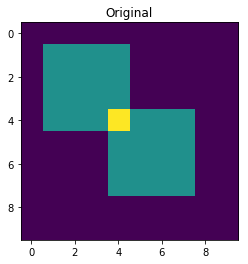

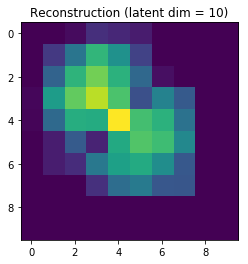

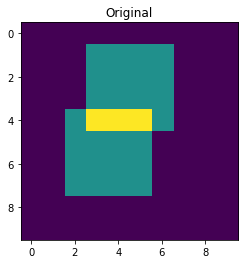

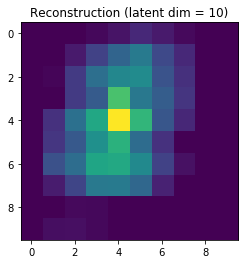

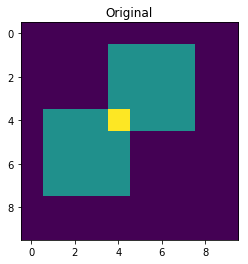

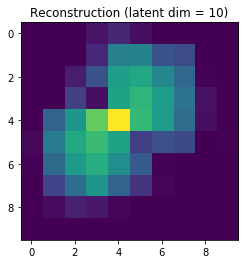

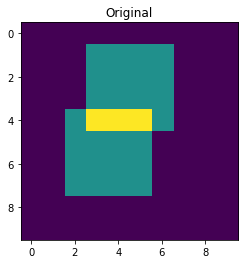

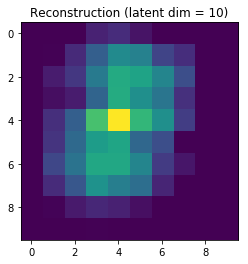

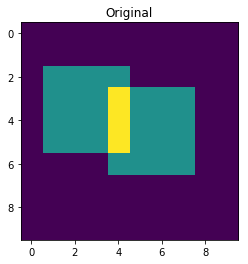

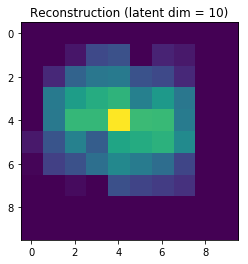

In [12]:
n = 1000
losses = run_train_sim(n)

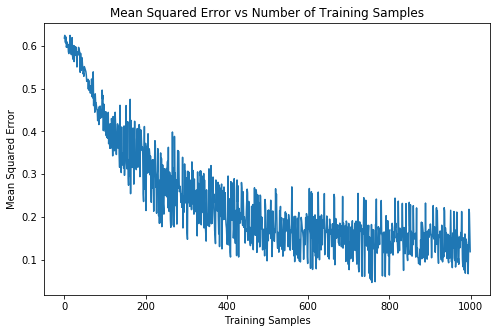

In [16]:
plt.figure(figsize=(8, 5))
plt.title('Mean Squared Error vs Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.xlabel('Training Samples')
plt.plot([i for i in range(n)], losses)
plt.show()